In [1]:
import asyncio
import collections
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from docx import Document
from rpy2.robjects import r, pandas2ri
import editdistance

import sys
sys.path.append("../")

import importlib
import llm_models
importlib.reload(llm_models)

from llm_models.utils import setup_transmission_chain
from llm_models.tasks import TaskFactory
from llm_models.enums import TaskType, AzureOpenAIModelType
from llm_models.node import Node
from llm_models.openai_model import AzureOpenAIModel

study_data = Path("../llm_models/study-data/").resolve()
LANCER, FLASH, NUTANE = "lancer", "flash", "nutane"
STUDIES = [LANCER, FLASH, NUTANE]
STORIES_PATH = {
    LANCER: "stories/blaine_boyer_lancer.txt",
    FLASH: "stories/blaine_boyer_flash.txt",
    NUTANE: "stories/blaine_boyer_nutane.txt",
}

EXP_OUTPUT_PATH = {
    LANCER: "output/Threat - Lancer.docx",
    FLASH: "output/Threat - Flash Ultra Color.docx",
    NUTANE: "output/Threat - Nutane.docx",
}

THREAT = "Threat"
NEGATIVE = "Negative"
NEUTRAL = "Neutral"

# 
statement_type = [THREAT] * 2 + [NEGATIVE] * 2 + [NEUTRAL] * 4
statement_counts = [0, 7, 6, 5, 4, 3] # number of statements at each step
cum_sum_statement_counts = np.cumsum(statement_counts)


lmer_levels = "c(" + f'"{NEUTRAL}", "{NEGATIVE}", "{THREAT}"' + ")"

LABEL_COLORS = [(THREAT, 'orange'), (NEGATIVE, 'black'), (NEUTRAL, "gray")]
LINESTYLES = ["-", ":", "--"]
EXP = ['GPT/HumanEval', 'GPT/GPTEval', 'GPT/GPTEval(New)']

%load_ext autoreload
%autoreload 2

### Helper functions

In [62]:
def normalize_string(s):
    """Normalizes string s."""
    standardized = s.replace('’', '')
    standardized = standardized.replace("'", '')
    stripped = " ".join(standardized.split())
    return stripped

def get_index(statements, x):
    """Returns the index in statements matching x."""
    for idx, statement in enumerate(statements):
        levenshtein_distance = editdistance.eval(x, statement)
        if levenshtein_distance < 10:
            return idx

def convert_annotations_to_proportions(results):
    """Converts annotations to final data for lmer and plotting.
    IMPORTANT: ADJUST ACCORDING TO THE TASK.
    """
    data = []
    for col in results.columns:
        if col == "original":
            continue
    
        chain_id = int(col[4])
        step_id = int(col[-1])

        for label in [THREAT, NEGATIVE, NEUTRAL]:
            prop = 1. * results.loc[label, col] / results.loc[label, 'original']
            x = (chain_id, step_id, prop, label)
            data.append(x)
    
    data = pd.DataFrame(data, columns=["chain_id", "chain_step", "proportion", "content"])
    return data


def lmer(data, str_levels=None):
    """Performs LMER."""
    pandas2ri.activate() 

    # Load the lme4 library in R
    r('library(lme4)')
    r('library(lmerTest)')
    
    # Convert the DataFrame to an R data.frame
    rdf = pandas2ri.py2rpy(data)
    
    # Fit the model in R
    r.assign('rdf', rdf)
    if str_levels is None:
        levels = data['content'].unique()
        str_levels = "c(" + ",".join([f'"{cat}"' for cat in levels]) +  ")"

    r(f'rdf$content <- factor(rdf$content, levels = {str_levels})')
    model = r('lmer(proportion ~ content + (1|chain_step) + (1|chain_id), data=rdf)')
    
    # Print the summary
    print(r('summary')(model))


def plot(ALL_DATA, ax):
    """Plots all the data. """
    label_used = False
    for idx, key in enumerate(EXP):
        if key not in ALL_DATA:
            continue
        plot_data = ALL_DATA[key]
        max_gen = int(plot_data["chain_step"].max())
        for label, color in LABEL_COLORS:
            means, stds = [], []
            for gen in range(max_gen+1):
                filter = (plot_data["chain_step"] == gen) & (plot_data["content"] == label)
                means.append(plot_data.loc[filter, "proportion"].mean())
                stds.append(plot_data.loc[filter, "proportion"].std() / np.sqrt(sum(filter)))
            use_label = label if not label_used else None 
            alpha = 0.25 if idx > 0 else 0.75 # emphasize the first one
            ax.plot(range(max_gen + 1), means, color=color, alpha=alpha, label=use_label)
            ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=alpha, capsize=2, linewidth=1, linestyle=LINESTYLES[idx])
            ax.scatter(range(max_gen + 1), means, color=color)
        label_used = True if use_label else False

    return ax


def convert_selections_to_count(exp_data):
    results_exp = {}
    
    for study in STUDIES:
        statements = STUDY_DATA[study]["statements"]
        if study not in exp_data:
            continue
        exp_selections = exp_data[study]
    
        for sim_id in exp_selections:
            step_id = 0
            for start, stop in zip(cum_sum_statement_counts, cum_sum_statement_counts[1:]):
                selected_statements = exp_selections[sim_id]['statements'][start: stop]
                
                col = f"sim:{sim_id} gen:{step_id}"
                if col in results_exp:
                    counts = results_exp[col]
                else:
                    counts = {THREAT: 0, NEGATIVE: 0, NEUTRAL: 0}
                
                for x in selected_statements:
                    if not x:
                        continue
                    idx = get_index(statements, x)
                    try:
                        counts[statement_type[idx]] += 1
                    except:
                        print("failed to find relevant idx", x)
                        
                results_exp[col] = counts
                step_id += 1
        
    results_exp['original'] = {
        THREAT: len(STUDIES) * statement_type.count(THREAT) , 
        NEGATIVE: len(STUDIES) * statement_type.count(NEGATIVE), 
        NEUTRAL: len(STUDIES) * statement_type.count(NEUTRAL)
    }
    results = pd.DataFrame(results_exp)
    results = results.fillna(0)
    return results

## Authors' Results

In [4]:
# collect the experimental data
STUDY_DATA = {}
EXP_SELECTIONS = {}
for study in STUDIES:

    # Narratives and corresponding statements
    narrative_path = study_data / STORIES_PATH[study]
    narrative = open(str(narrative_path)).read()
    
    raw_statements = narrative.split("Here are the statements:")[-1].strip().split("\n")
    statements = []
    for raw in raw_statements:
        if not raw:
            continue

        statement = normalize_string(raw)
        statements.append(statement)

    # Experimental selections published in the paper
    summaries = []
    doc = Document(str(study_data / EXP_OUTPUT_PATH[study]))
    for para in doc.paragraphs:
        if para.text:
            summaries.append(para.text)
    
    exp_selections = {}
    
    for x in summaries:
        if x.startswith("CHAIN"):
            sim_id = int(x.split()[-1])
            exp_selections[sim_id] = {}
        elif x.startswith("Random sequence:"):
            treatment = x.split("Random sequence:")[-1].strip().split()
            treatment = list(map(int, treatment))
            exp_selections[sim_id]['treatment'] = treatment
        else:
            nrm_x = normalize_string(x)
            if "statements" in exp_selections[sim_id]:
                exp_selections[sim_id]["statements"].append(nrm_x)
            else:
                exp_selections[sim_id]["statements"] = [nrm_x] 

    STUDY_DATA[study] = {
        "statements": statements,
        # "selections": exp_selections
    }

    EXP_SELECTIONS[study] = exp_selections

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -66.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.67056 -0.74503 -0.02454  0.71380  1.63678 

Random effects:
 Groups     Name        Variance Std.Dev.
 chain_step (Intercept) 0.02708  0.1646  
 chain_id   (Intercept) 0.00000  0.0000  
 Residual               0.01690  0.1300  
Number of obs: 75, groups:  chain_step, 5; chain_id, 5

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      0.47667    0.07805  4.66309   6.107  0.00217 ** 
contentNegative  0.07000    0.03677 68.00000   1.904  0.06120 .  
contentThreat    0.52333    0.03677 68.00000  14.231  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) cntntN
contentNgtv -0.236       
contentThrt -0.

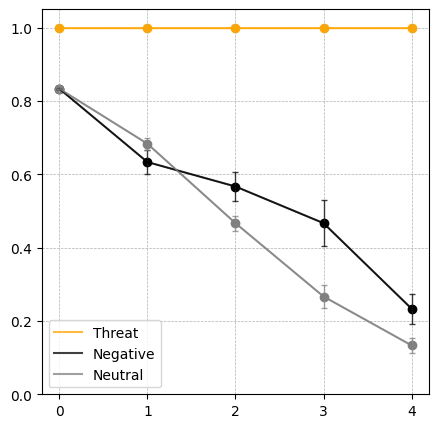

In [65]:
results_exp = convert_selections_to_count(EXP_SELECTIONS)
data_exp = convert_annotations_to_proportions(results_exp)

#lmer

lmer(data_exp, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
plot(ALL_DATA, ax)

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_ylim(0, 1.05)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()

## New Experiment / GPT-4 Evaluation

In [83]:
# define the api and task
llm_model_execute = AzureOpenAIModel(AzureOpenAIModelType.GPT_3_5_TURBO, {})
# llm_model_execute = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 1000})
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})


# define simulations asynchornously
async def run_simulation(connecitons, task, sim_idx):
    all_nodes = setup_transmission_chain(connections, Node, task, sim_idx)
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation ])
    return all_nodes

# define the chain
connections = [
    [[0]],
    [[0]],
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5

routines = []
for study in STUDIES:
    task = TaskFactory.create(TaskType.THREAT, llm_model_execute, llm_model_evaluate, study=study)
    routines += [run_simulation(connections, task, idx) for idx in range(n_simulations)]

simulations = await asyncio.gather(*routines)

for i, all_nodes in enumerate(simulations):
    print(f"Simulation {i + 1} completed.")

sent output to  [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  0 (0, 0)
sent output to  [Sim:3 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  3 (0, 0)
sent output to  [Sim:4 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  4 (0, 0)
sent output to  [Sim:1 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  1 (0, 0)
sent output to  [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  0 (0, 0)
sent output to  [Sim:3 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  3 (0, 0)
sent output to  [Sim:2 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  2 (0, 0)
sent output to  [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  0 (0, 0)
sent output to  [Sim:1 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  1 (0, 0)
sent output to  [Sim:2 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
in:  2 (0, 0)
sent output to  [Sim

In [84]:
# prepare data for analysis
selections = {}
for i in range(1, len(STUDIES)+1):
    study = STUDIES[i-1]
    selections[study] = {}
    exps = simulations[(i-1)*n_simulations:i*n_simulations]
    for sim_id, all_nodes in enumerate(exps):
        selections[study][sim_id] = {'statements': [], 'treatment': None} # a simulation is treatment and selected statements
        node_selections = []
        for generation in all_nodes:
            for node in generation:
                node_selections += node.output # output is a list
        selections[study][sim_id]['statements'].extend(node_selections) # each list a selection
        print(sim_id, len(node_selections))
        for x in node_selections:
            print(x)

0 25
Lancer™ is a luxury running shoe brand that comes in many shapes and sizes.
Lancer™s customization process analyzes the way you run.
Lancer™ shoes last up to a year longer than other brands.
Lancer™ builds a unique shoe tailored especially for you.
Lancer™s strap design can cause sprained ankles when used for activities other than running.
Lancer™s smooth sole can cause runners to slip and fall on certain surfaces.
Lancer™ are only available in white and do not come in other colors.
Lancer™ is a luxury running shoe brand that comes in many shapes and sizes.
Lancer™s customization process analyzes the way you run.
Lancer™ shoes last up to a year longer than other brands.
Lancer™ builds a unique shoe tailored especially for you.
Lancer™s strap design can cause sprained ankles when used for activities other than running.
Lancer™ are only available in white and do not come in other colors.
Lancer™ is a luxury running shoe brand that comes in many shapes and sizes.
Lancer™s customizati

In [85]:
results = convert_selections_to_count(selections)
data = convert_annotations_to_proportions(results)

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -98.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4352 -0.6138  0.1961  0.5935  1.8508 

Random effects:
 Groups     Name        Variance Std.Dev.
 chain_step (Intercept) 0.03784  0.1945  
 chain_id   (Intercept) 0.00000  0.0000  
 Residual               0.01044  0.1022  
Number of obs: 75, groups:  chain_step, 5; chain_id, 5

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      0.63333    0.08936  4.29362   7.087  0.00160 ** 
contentNegative -0.12000    0.02889 68.00004  -4.153 9.36e-05 ***
contentThreat    0.08667    0.02889 68.00004   2.999  0.00378 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) cntntN
contentNgtv -0.162       
contentThrt -0.162  0.500

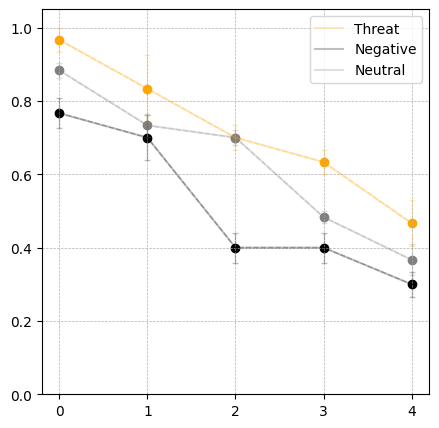

In [86]:

#lmer

lmer(data, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
# ALL_DATA[EXP[0]] = data_exp
ALL_DATA[EXP[2]] = data
plot(ALL_DATA, ax)

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_ylim(0, 1.05)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()
